# Data analysis for first population
**INCLUDE:**
1. Data exploration
2. Classification
3. Regression

In [2]:
#Data processing
import numpy as np
import pandas as pd
from scipy import stats


#Plotting
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns;  sns.reset_orig()

#Analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#Common Model Algorithms
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LinearRegression

#Machine Learning
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn import tree
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#Helpers
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from Residual_Visualization import regression_residual_plots
from Confusion_matrix import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from feature_cutting import drop_feature

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


--------------------

In [3]:
#Read in data

In [4]:
df = pd.read_csv('/Users/duc_hoang/Box Sync/Fermilab Summer Research/CNN-Architectural-Analysis/MINERvA-Vertex-Finding/Data/First-population/First-population-attributes.csv', index_col = 0)

In [5]:
df = df.dropna()

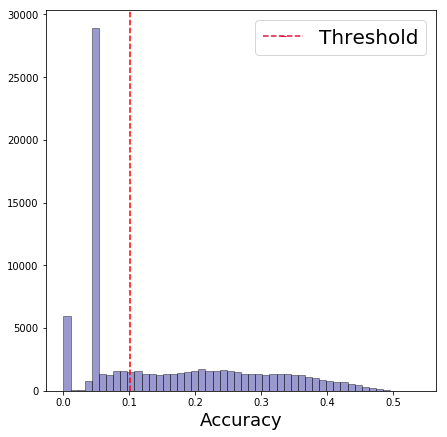

In [6]:
#histogram
fig = plt.figure(figsize=[7,7])
fig1 = sns.distplot(df["final_accuracy"],
                    hist=True, kde=False, 
                    color = 'darkblue',
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth': 2}, norm_hist=False);

fig1.set_xlabel("Accuracy", fontsize = 18)
plt.axvline(x = 0.100533, ls = "--", c = "red")

# Manually add legend
threshold = mlines.Line2D([], [], color='crimson', marker='_', linestyle='--',
                                    markersize=6, label='Threshold', alpha = 1)

plt.legend(handles=[threshold], fontsize = 20)

----------

In [7]:
#Classification models

In [8]:
#Select the features and dependent variable
X = df.drop(columns=['initial_accuracy','final_accuracy', 'genealogy']) #Features
y = pd.Series([0 if x < 0.100533 else 1 for x in df['final_accuracy']]) #dependent variable

In [9]:
#Divide train and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=0)

In [10]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [11]:
#Explore random forest
rf = RandomForestClassifier(n_estimators=150, max_depth = 17, min_samples_split=40,
                            bootstrap = False, warm_start = True, random_state=0)

rf.fit(X_train, y_train)

print("Accuracy : %f" % rf.score(X_test, y_test))

Accuracy : 0.667203


In [12]:
rf_cross_val = cross_val_score(rf, X_train, y_train, cv = 5)
print("Average cross-validation score on train set: ", np.average(rf_cross_val))
print("Standard deviation of the cross validation scores: ", np.std(rf_cross_val))

Average cross-validation score on train set:  0.6731973739953748
Standard deviation of the cross validation scores:  0.004116020292896624


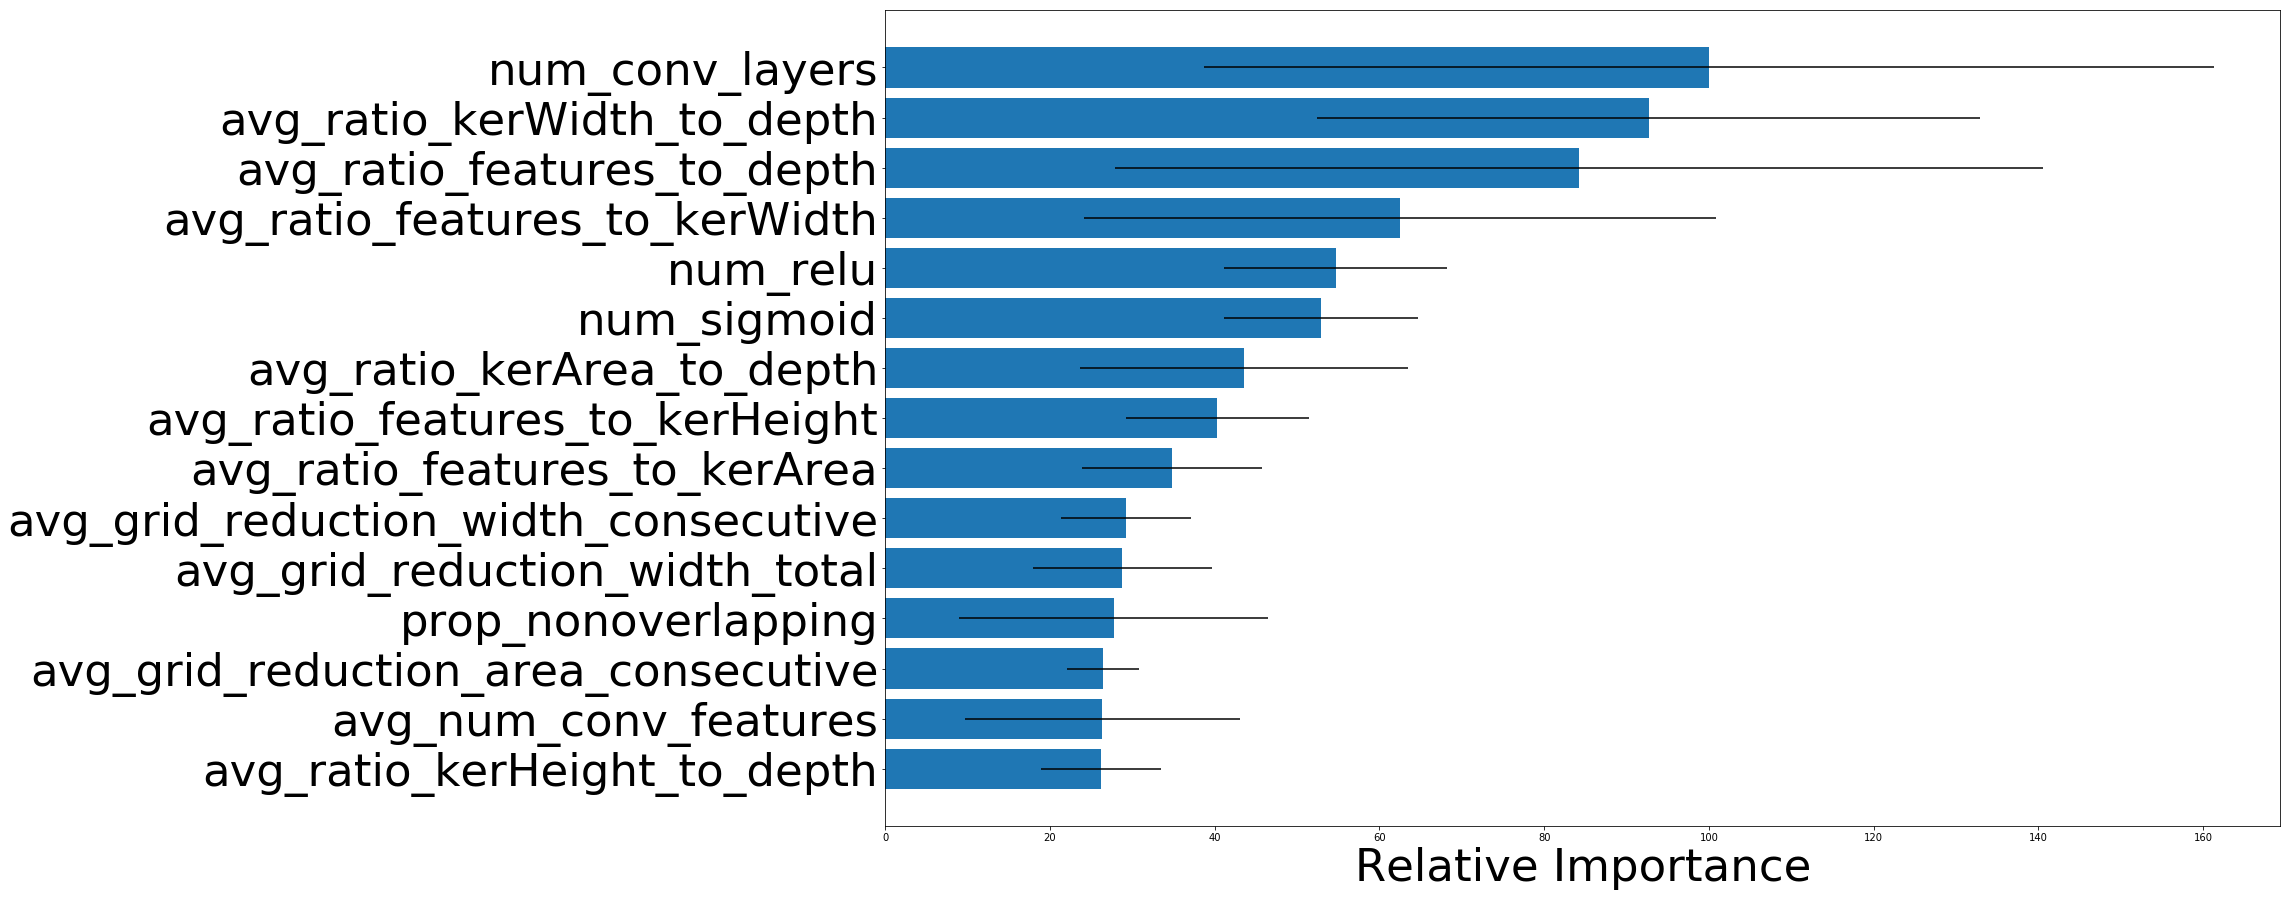

In [13]:
#Feature Importance extraction
feature_importance1 = rf.feature_importances_

# Compute the standard deviation
std1 = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

#scale the std first
std1 = 100.0 * (std1/ feature_importance1.max())

# make importances relative to max importance
feature_importance1 = 100.0 * (feature_importance1 / feature_importance1.max())

features_importance_rf1 = pd.DataFrame({'Feature':X.columns,'Importance':feature_importance1, "Error":std1})

Sorted_Features_importance_rf1 = features_importance_rf1.sort_values(by=['Importance'])

#Just show the first 15 most important features
toShow_15 = Sorted_Features_importance_rf1.iloc[-15:,:]
pos = np.arange(toShow_15.shape[0]) + .5

#Plotting
fig = plt.figure(figsize = [25,15])
plt.barh(pos, toShow_15['Importance'], align='center', xerr = toShow_15['Error'])
plt.yticks(pos, toShow_15['Feature'], fontsize = 45)
plt.xlabel('Relative Importance', fontsize = 45)
plt.show()

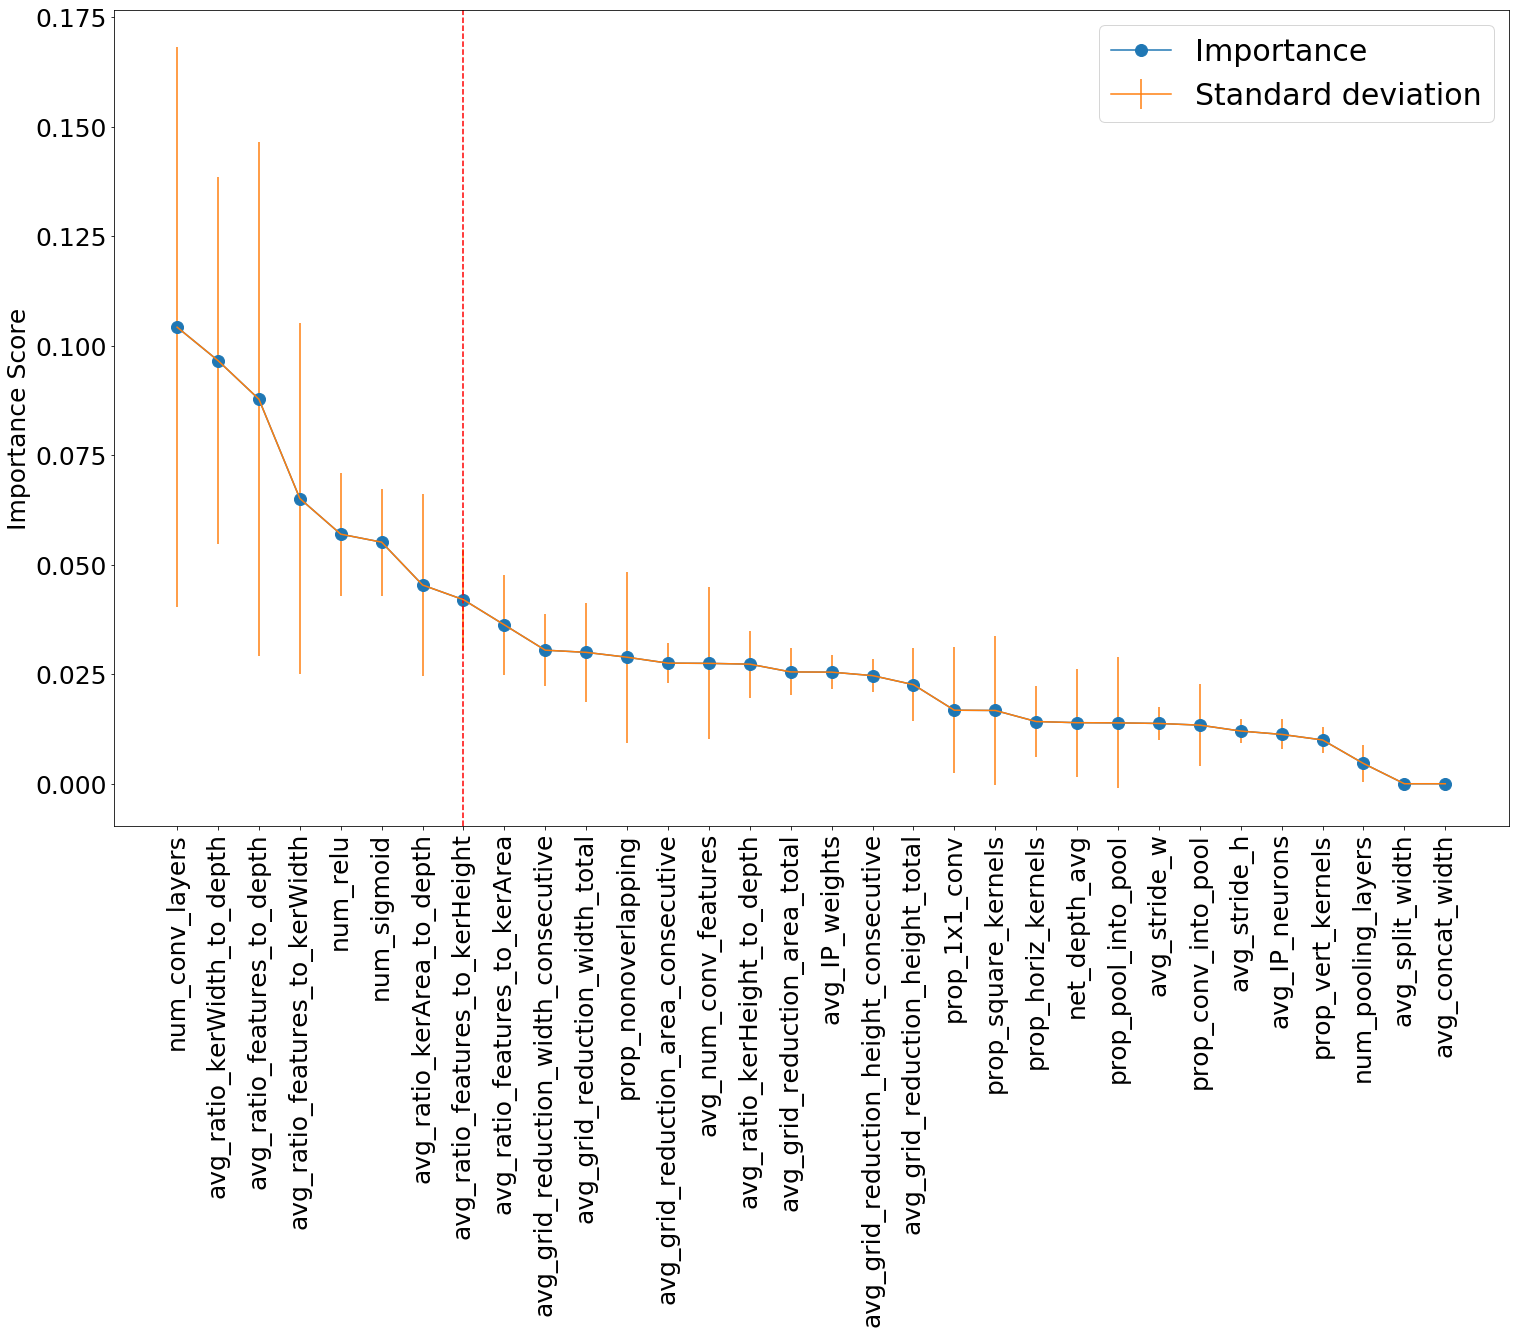

In [15]:
#Make connected dot plot for feature importance

#Feature Importance extraction
feature_importance1 = rf.feature_importances_

# Compute the standard deviation
std1 = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

features_importance_rf1 = pd.DataFrame({'Feature':X.columns,'Importance':feature_importance1, "Error":std1})

Sorted_Features_importance_rf1 = features_importance_rf1.sort_values(by=['Importance'], ascending = False)

#Position for x axis
pos = np.arange(Sorted_Features_importance_rf1.shape[0]) + .5

#Plotting
fig = plt.figure(figsize = [25,15])
plt.plot(pos, Sorted_Features_importance_rf1["Importance"], '-o', markersize = 12)
plt.errorbar(pos, Sorted_Features_importance_rf1["Importance"], yerr= Sorted_Features_importance_rf1["Error"],
             label = "Standard deviation")
plt.legend(loc="best", fontsize = 30)
plt.xticks(pos, Sorted_Features_importance_rf1['Feature'], rotation = "vertical", fontsize = 25)
plt.yticks(fontsize=25)
plt.ylabel("Importance Score", fontsize = 25)

#Add dotted line
plt.axvline(x = 7 + 0.5, ls = "--", c = "red")
plt.show()


In [16]:
#Dropping most important features
rf_crvals, std_rf_crvals, num_trimmed = drop_feature(rf,Sorted_Features_importance_rf1, X, y, 15)

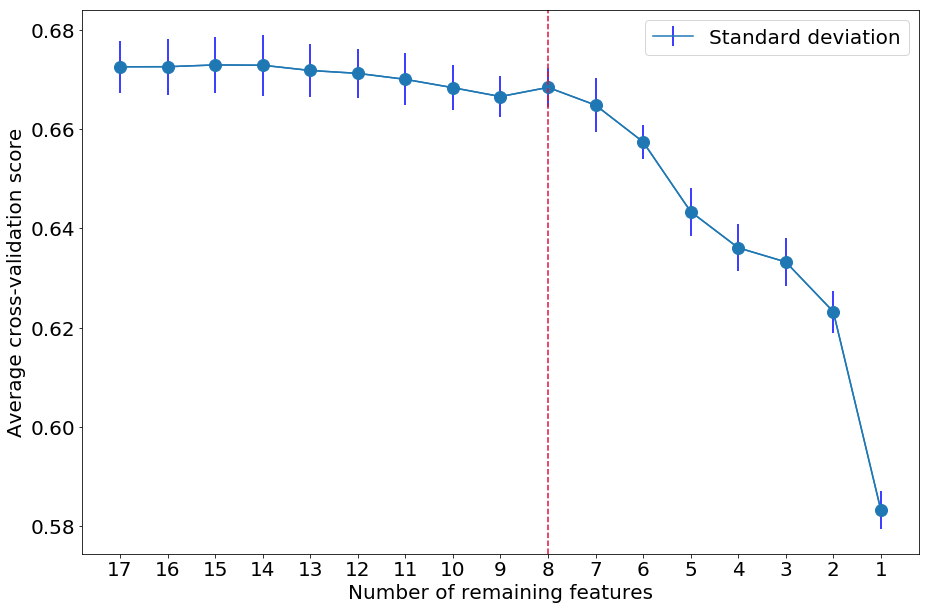

In [44]:
#Plotting
num_remaining = X.shape[1] - np.array(num_trimmed)

fig = plt.figure(figsize = [15,10])
plt.plot(num_trimmed, rf_crvals,'-o', markersize = 12)

#Set ticks
plt.yticks(fontsize = 20)
plt.xticks(num_trimmed,num_remaining, fontsize = 20)

#Error bars
plt.errorbar(num_trimmed, rf_crvals, yerr= std_rf_crvals, ecolor = "blue",
            label='Standard deviation')

plt.legend(loc="best", fontsize = 20)

#Set labels
plt.ylabel("Average cross-validation score", fontsize = 20)
plt.xlabel("Number of remaining features", fontsize = 20)

#Set cut off
plt.axvline(x = 24, ls = "--", c = "crimson")

----------

In [17]:
ext = ExtraTreesClassifier(n_estimators=50, max_depth=24, 
                           min_samples_split=50, bootstrap = False, 
                            warm_start = True, random_state=0)
ext.fit(X_train, y_train)

print("Accuracy : %f" % ext.score(X_test, y_test))

Accuracy : 0.660414


In [18]:
ext_cross_val = cross_val_score(ext, X_train, y_train, cv = 5)
print("Cross-validation score on train set: ", np.average(ext_cross_val))
print("Standard deviation of cross validation score: ", np.std(ext_cross_val) )

Cross-validation score on train set:  0.6671682256547745
Standard deviation of cross validation score:  0.006450416505731649


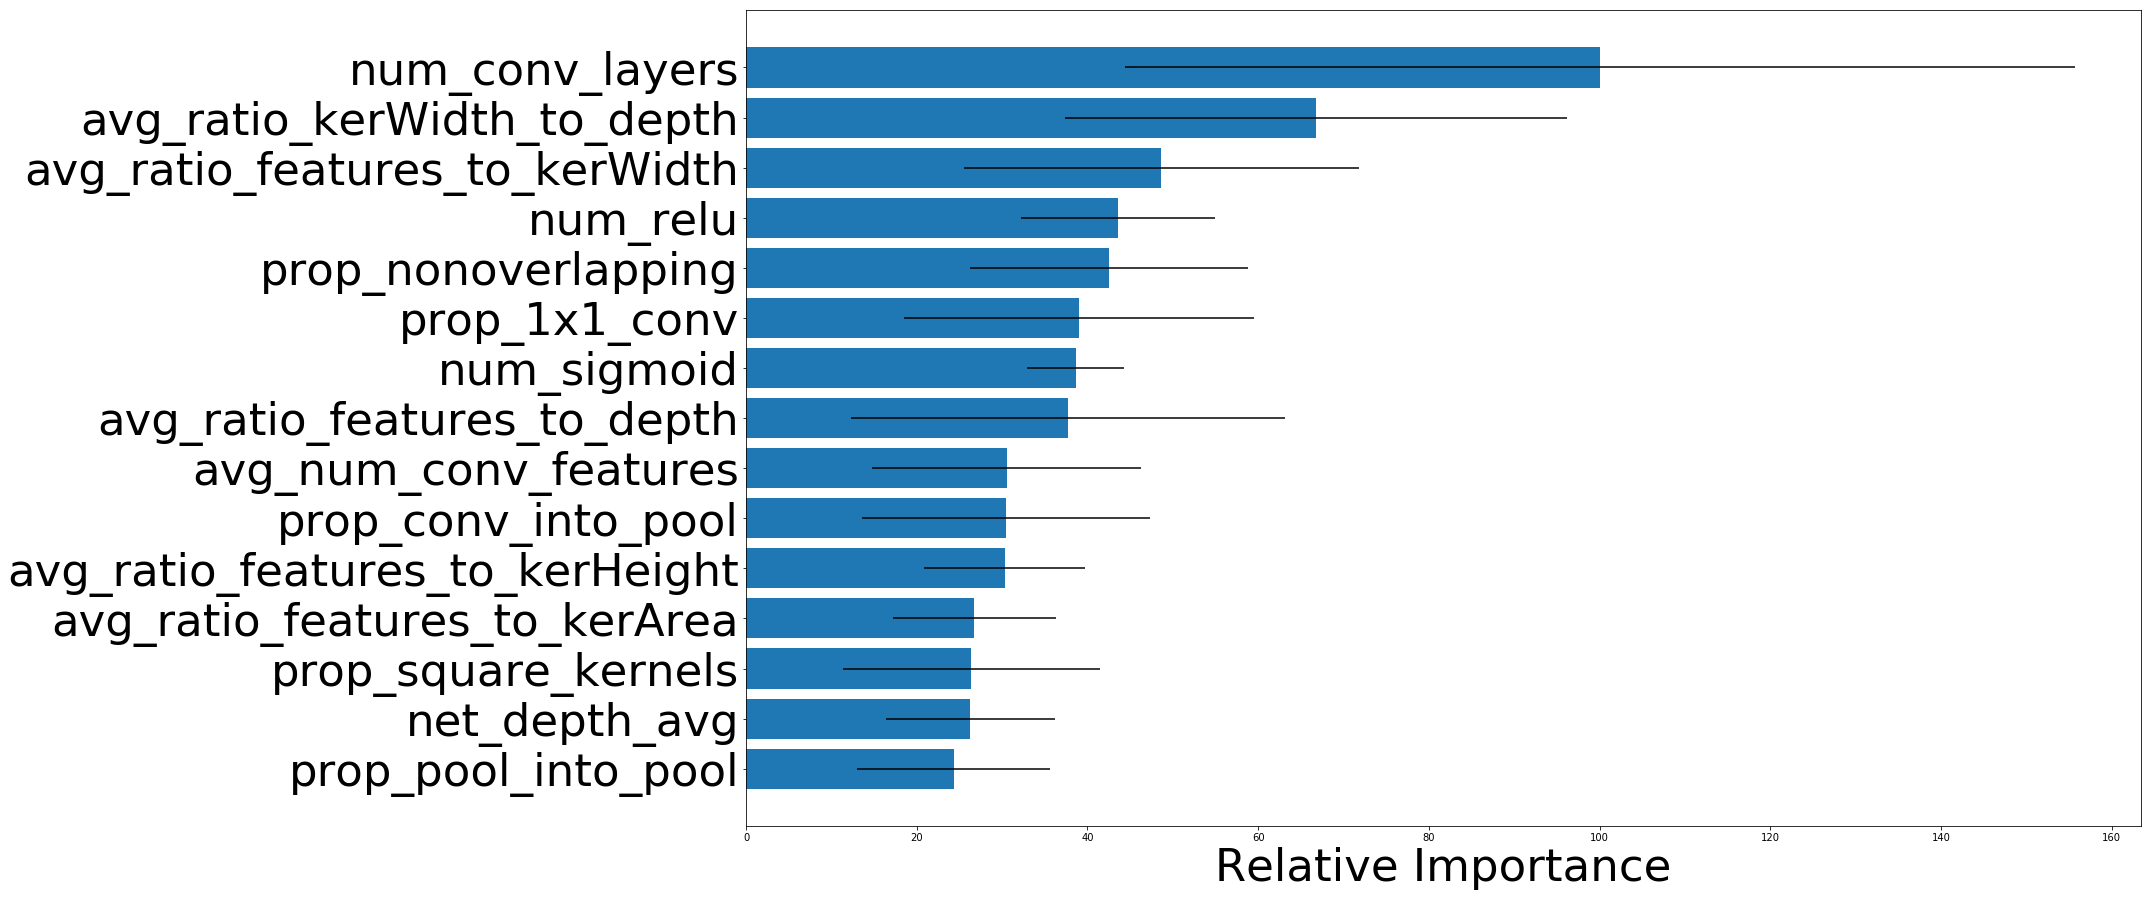

In [19]:
#Feature importance extraction from model
feature_importance11 = ext.feature_importances_

# Compute the standard deviation
std11 = np.std([tree.feature_importances_ for tree in ext.estimators_], axis=0)

#scale the std first
std11 = 100.0 * (std11/ feature_importance11.max())

# make importances relative to max importance
feature_importance11 = 100.0 * (feature_importance11 / feature_importance11.max())

features_importance_rf11 = pd.DataFrame({'Feature':X.columns,'Importance':feature_importance11, "Error":std11})

Sorted_Features_importance_rf11 = features_importance_rf11.sort_values(by=['Importance'])

#Just show the first 15 most important features
toShow_151 = Sorted_Features_importance_rf11.iloc[-15:,:]

pos = np.arange(toShow_151.shape[0]) + .5

fig = plt.figure(figsize = [25,15])
plt.barh(pos, toShow_151['Importance'], align='center', xerr = toShow_151['Error'])
plt.yticks(pos, toShow_151['Feature'], fontsize = 45)
plt.xlabel('Relative Importance', fontsize = 45)
plt.show()

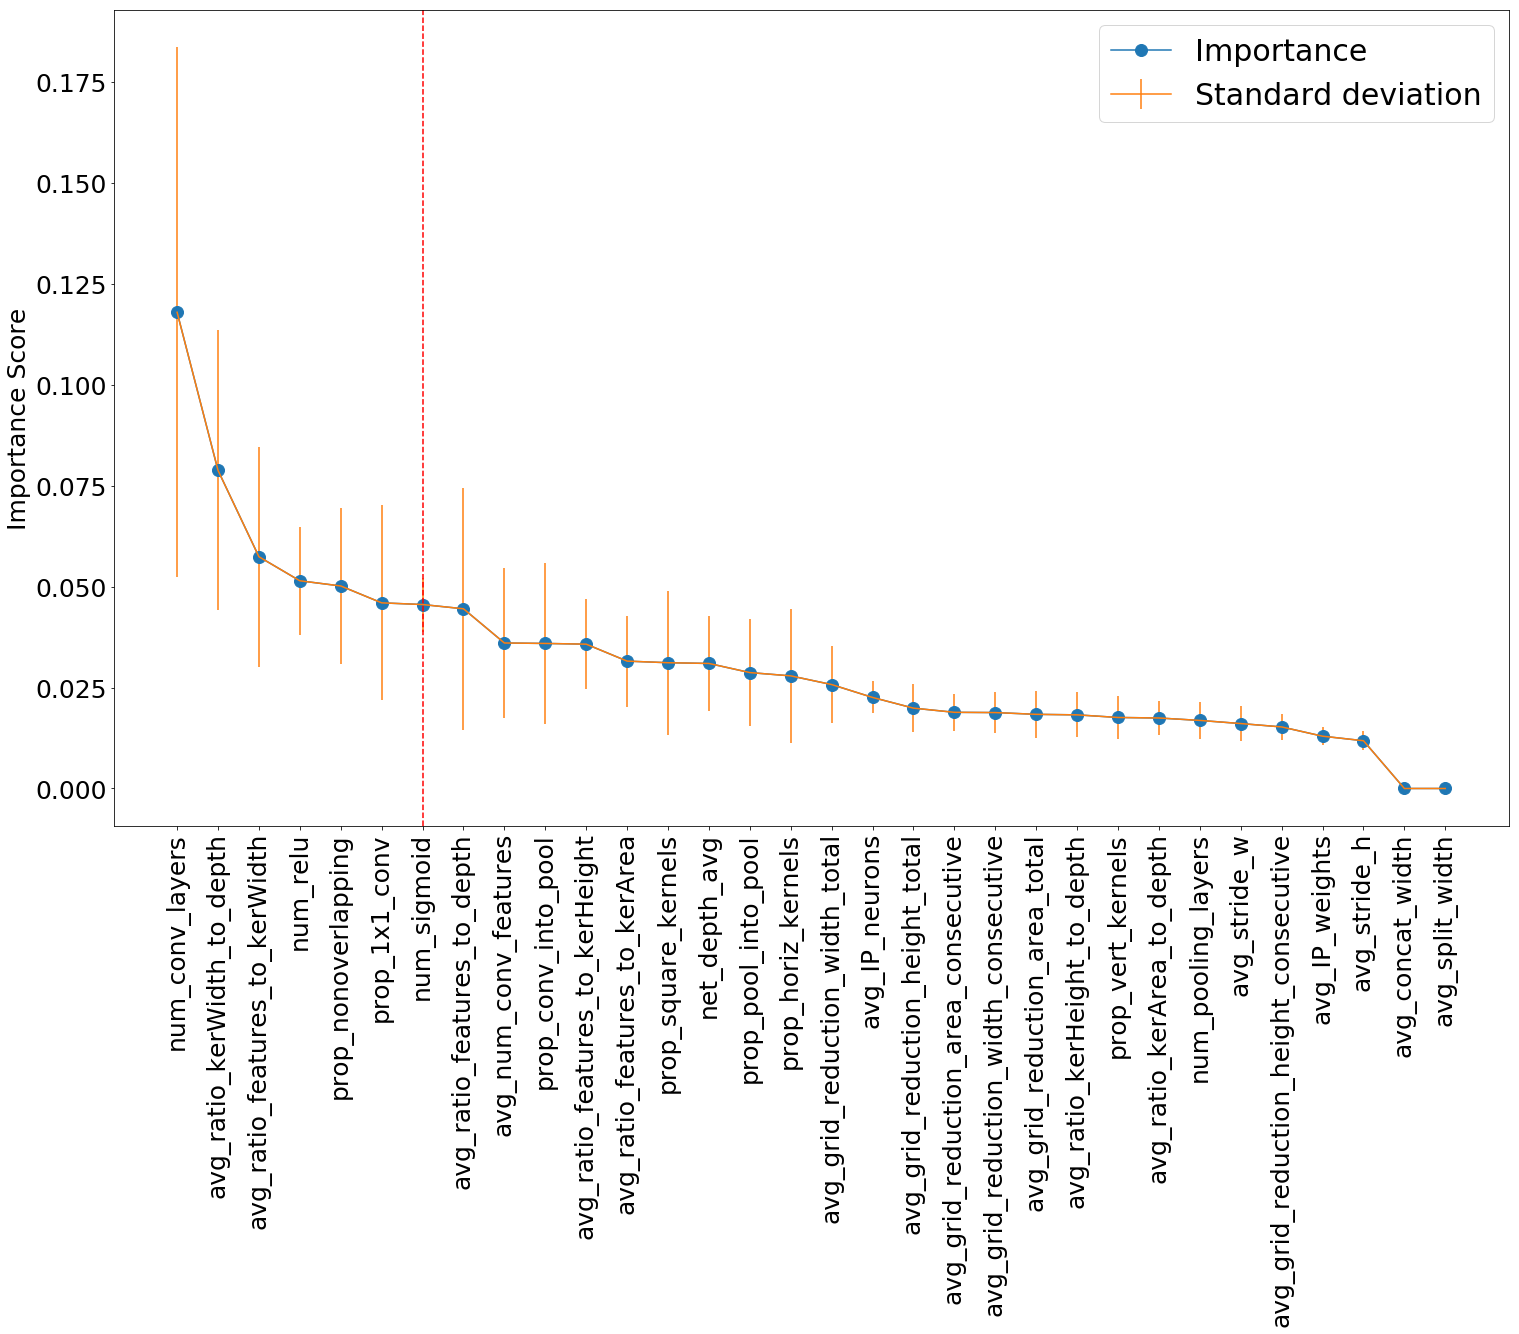

In [23]:
#Make connected dot plot for feature importance

#Feature importance extraction from model
feature_importance11 = ext.feature_importances_

# Compute the standard deviation
std11 = np.std([tree.feature_importances_ for tree in ext.estimators_], axis=0)

features_importance_rf11 = pd.DataFrame({'Feature':X.columns,'Importance':feature_importance11, "Error":std11})

Sorted_Features_importance_rf11 = features_importance_rf11.sort_values(by=['Importance'], ascending = False)

#Position for x axis
pos = np.arange(Sorted_Features_importance_rf11.shape[0]) + .5

#Plotting
fig = plt.figure(figsize = [25,15])
plt.plot(pos, Sorted_Features_importance_rf11["Importance"], '-o', markersize = 12)
plt.errorbar(pos, Sorted_Features_importance_rf11["Importance"], yerr= Sorted_Features_importance_rf11["Error"], label = "Standard deviation")
plt.xticks(pos, Sorted_Features_importance_rf11['Feature'], rotation = "vertical", fontsize = 25)
plt.yticks(fontsize=25)
plt.ylabel("Importance Score", fontsize = 25)
plt.legend(loc = "best", fontsize = 30)

#Add dotted line
plt.axvline(x = 6 + 0.5, ls = "--", c = "red")
plt.show()

plt.show()

In [55]:
#Dropping most important features
ext_crvals, std_ext_crvals, ext_num_trimmed = drop_feature(ext, Sorted_Features_importance_rf11, X, y, 15)

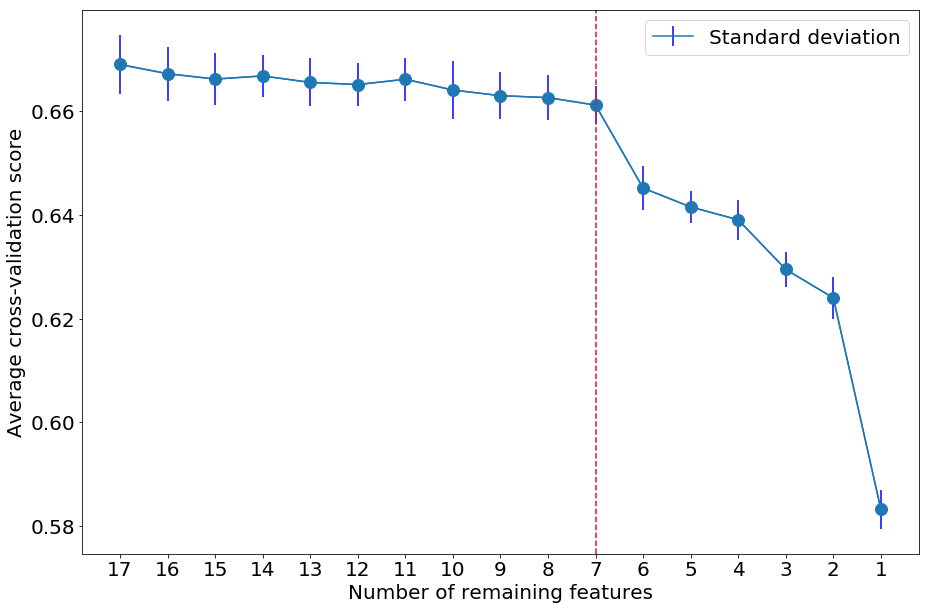

In [57]:
#Plotting
num_remaining = X.shape[1] - np.array(ext_num_trimmed)

fig = plt.figure(figsize = [15,10])
plt.plot(num_trimmed, ext_crvals,'-o', markersize = 12)

#Set ticks
plt.yticks(fontsize = 20)
plt.xticks(num_trimmed,num_remaining, fontsize = 20)

#Error bars
plt.errorbar(num_trimmed, ext_crvals, yerr= std_ext_crvals, ecolor = "blue",
            label='Standard deviation')

plt.legend(loc="best", fontsize = 20)

#Set labels
plt.ylabel("Average cross-validation score", fontsize = 20)
plt.xlabel("Number of remaining features", fontsize = 20)

#Set cut off
plt.axvline(x = 25, ls = "--", c = "crimson")

-----------

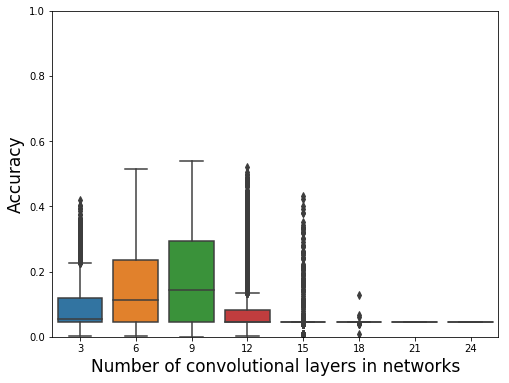

In [38]:
#box plot
var = 'num_conv_layers'
data = pd.concat([df['final_accuracy'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="final_accuracy", data=data)
plt.xlabel("Number of convolutional layers in networks", fontsize = 17)
plt.ylabel("Accuracy", fontsize = 17)
fig.axis(ymin=0, ymax=1);

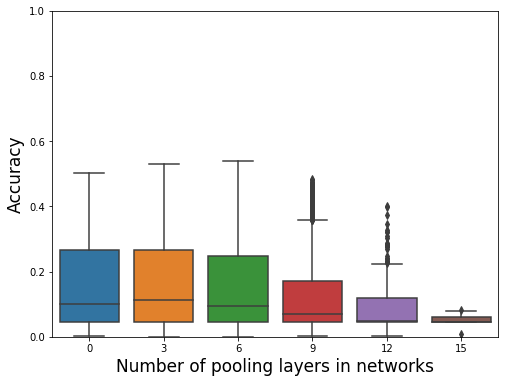

In [39]:
#box plot
var = 'num_pooling_layers'
data = pd.concat([df['final_accuracy'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="final_accuracy", data=data)
plt.xlabel("Number of pooling layers in networks", fontsize = 17)
plt.ylabel("Accuracy", fontsize = 17)
fig.axis(ymin=0, ymax=1);

In [9]:
df['group_name'] = ['Broken Networks' if x < 0.100533 else "Healthy Networks" for x in df['final_accuracy']]

Text(0.5, 0, '')

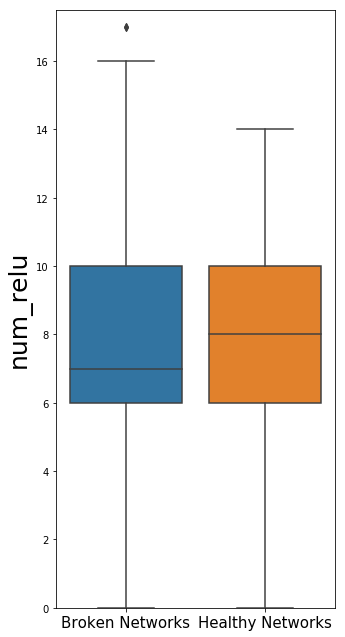

In [62]:
var = 'group_name'
data = pd.concat([df['num_relu'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(5, 11))
fig = sns.boxplot(x=var, y='num_relu', order = ["Broken Networks","Healthy Networks"], data=data)
fig.axis(ymin=0, ymax=17.50);
plt.xticks(fontsize=15);
ax.yaxis.label.set_size(25)
fig.set_xlabel('')

Text(0.5, 0, '')

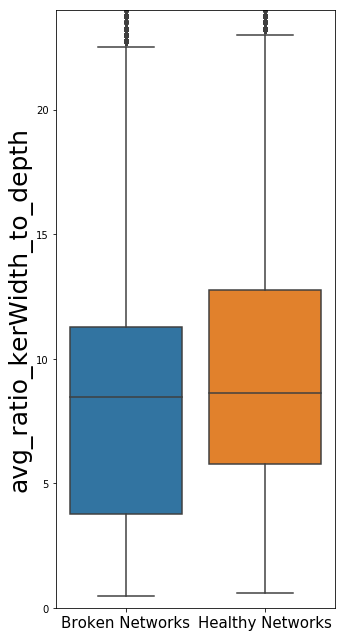

In [15]:
var = 'group_name'
data = pd.concat([df['avg_ratio_kerWidth_to_depth'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(5, 11))
fig = sns.boxplot(x=var, y='avg_ratio_kerWidth_to_depth', order = ["Broken Networks","Healthy Networks"], data=data)
fig.axis(ymin=0, ymax=24);
plt.xticks(fontsize=15);
ax.yaxis.label.set_size(25)
fig.set_xlabel('')

Text(0.5, 0, '')

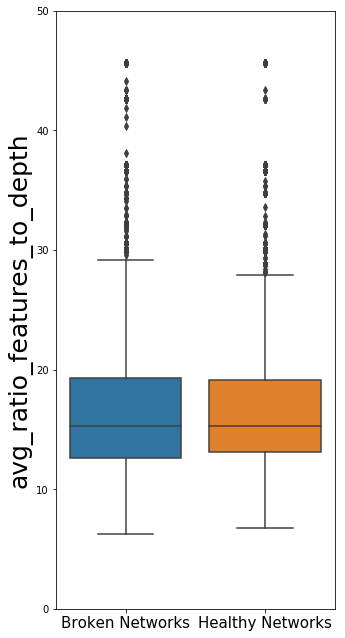

In [64]:
var = 'group_name'
data = pd.concat([df['avg_ratio_features_to_depth'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(5, 11))
fig = sns.boxplot(x=var, y='avg_ratio_features_to_depth', order = ["Broken Networks","Healthy Networks"], data=data)
fig.axis(ymin=0, ymax=50);
plt.xticks(fontsize=15);
ax.yaxis.label.set_size(25)
fig.set_xlabel('')

In [65]:
df['group'] = [0 if x < 0.100533 else 1 for x in df['final_accuracy']]

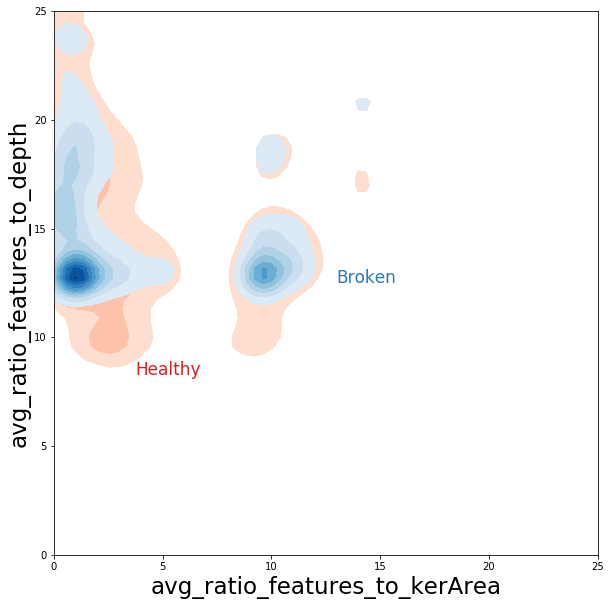

In [73]:
#avg_ratio_features_to_kerArea and avg_ratio_features_to_depth
data1 = df[df['group'] == 0]
data2 = df[df['group'] == 1]
# Set up the figure
f, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(data1['avg_ratio_features_to_kerArea'], data1['avg_ratio_features_to_depth'],
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(data2['avg_ratio_features_to_kerArea'], data2['avg_ratio_features_to_depth'],
                 cmap="Blues", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(13, 12.5, "Broken", size=17, color=blue)
ax.text(3.75, 8.25, "Healthy", size=17, color=red)
plt.xlim(0,25)
plt.ylim(0,25)
ax.yaxis.label.set_size(23)
ax.xaxis.label.set_size(23)

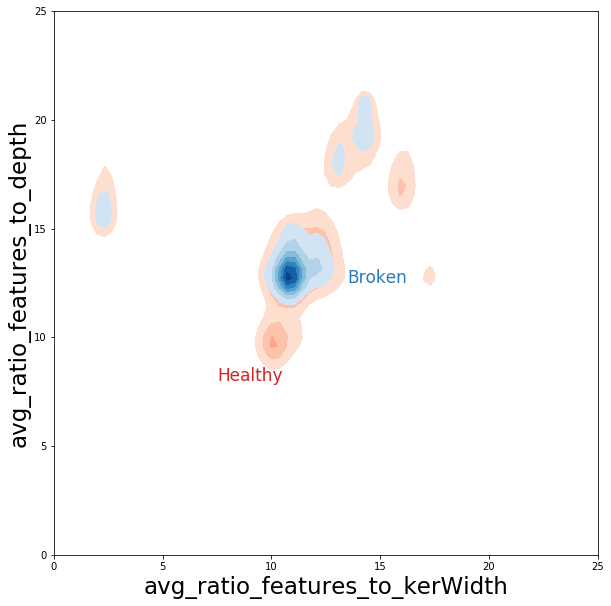

In [74]:
#avg_ratio_features_to_kerWidth and avg_ratio_features_to_depth
# Set up the figure
f, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(data1['avg_ratio_features_to_kerWidth'], data1['avg_ratio_features_to_depth'],
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(data2['avg_ratio_features_to_kerWidth'], data2['avg_ratio_features_to_depth'],
                 cmap="Blues", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(13.5, 12.5, "Broken", size=17, color=blue)
ax.text(7.5, 8, "Healthy", size=17, color=red)
plt.xlim(0,25)
plt.ylim(0,25)
ax.yaxis.label.set_size(23)
ax.xaxis.label.set_size(23)

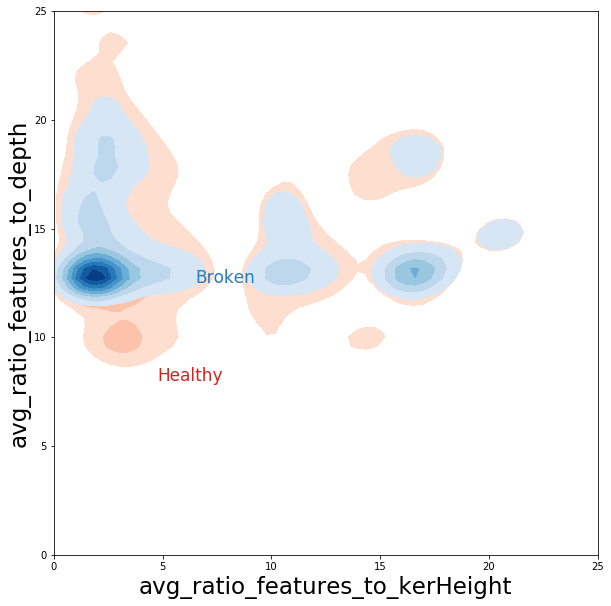

In [78]:
#avg_ratio_features_to_kerHeight and avg_ratio_features_to_depth
# Set up the figure
f, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(data1['avg_ratio_features_to_kerHeight'], data1['avg_ratio_features_to_depth'],
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(data2['avg_ratio_features_to_kerHeight'], data2['avg_ratio_features_to_depth'],
                 cmap="Blues", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(6.5, 12.5, "Broken", size=17, color=blue)
ax.text(4.75, 8, "Healthy", size=17, color=red)
plt.xlim(0,25)
plt.ylim(0,25)
ax.yaxis.label.set_size(23)
ax.xaxis.label.set_size(23)

---------------

In [24]:
#Linear models

In [12]:
#Select out the healthy parts
df = df[df["final_accuracy"] >= 0.100533]

In [13]:
df.shape

(41984, 35)

Text(0.5, 1.0, 'Transformed Accuracy')

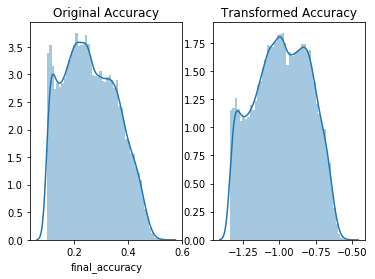

In [50]:
# normalize the exponential data with boxcox
normalized_accuracy = stats.boxcox(df["final_accuracy"])

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(df['final_accuracy'], ax=ax[0])
ax[0].set_title("Original Accuracy")
sns.distplot(normalized_accuracy[0], ax=ax[1])
ax[1].set_title("Transformed Accuracy")

In [51]:
#Feature + target
X = df.drop(columns=['initial_accuracy','final_accuracy', 'genealogy']) #Features
y = df['final_accuracy']

In [41]:
print("Feature Shape: ", X.shape)

Feature Shape:  (41984, 32)


In [42]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X)  
X = scaler.transform(X) 

In [31]:
poly = PolynomialFeatures(interaction_only = True, include_bias = False)
X = poly.fit_transform(X) #Create interaction terms

In [35]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     71.86
Date:                Fri, 26 Jul 2019   Prob (F-statistic):               0.00
Time:                        08:49:46   Log-Likelihood:                 23258.
No. Observations:               41984   AIC:                        -4.559e+04
Df Residuals:                   41519   BIC:                        -4.157e+04
Df Model:                         464                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0380      0.017      2.171      0.0